## Patterning
[Self-organized Notch dynamics generate stereotyped sensory organ patterns in Drosophila](https://www.science.org/doi/full/10.1126/science.aai7407?casa_token=_HGoX7kcWZcAAAAA%3AzoEGS_8EyLf7hNo9MC274EuqPACq6y4MsfCr93S9tzmmcK3pSTmNpJ7a7sc8HQMw5PETz7n9tG15jQ)

### Imports

In [2]:
# Adding packages
using Pkg
Pkg.add("CellBasedModels")
Pkg.add("GLMakie")
Pkg.add("Distributions")

# Enabling packages
using CellBasedModels
using GLMakie #Can be changed to CairoMakie
using Distributions
Makie.inline!(true)

   Resolving package versions...

  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Manifest.toml`


   Resolving package versions...

  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\s361359\.julia\environments\v1.9\Manifest.toml`


true

### Code

#### Creating the model

In [3]:
# Defining some functions
fσ(x) = (1+tanh(2*x))/2
fs0(x,t,l,S0,τg,L) = S0*fσ(1-t/τg)*(exp(-x^2/(2*L^2))+exp(-(1-x)^2/(2*L^2))) + fσ(t/τg-1)*(exp(-x^2/(2*l^2))+exp(-(1-x)^2/(2*l^2)))

fs0 (generic function with 1 method)

In [4]:
# Creating the ABM model 
model = ABM(2,  # The model has 2 dimensions

    agent = Dict(
        :s0 => Float64,
        :u => Float64,
        :s => Float64
    ),
    
    model = Dict(
        :a0=>Float64,
        :a1=>Float64,
        :τ=>Float64,
        :l=>Float64,
        :D=>Float64,
        :S0=>Float64,
        :τg=>Float64,
        :L=>Float64
    ),

    agentODE = quote    # deterministic term rule

        s0 = fs0(x,t,l,S0,τg,L)
        
        s = 0
        @loopOverNeighbors i2 begin
            d = minimum(
                        [
                            (x-x[i2])^2+(y-y[i2])^2,
                            (x-x[i2]+1)^2+(y-y[i2])^2,
                            (x-x[i2]-1)^2+(y-y[i2])^2,
                            (x-x[i2])^2+(y-y[i2]+1)^2,
                            (x-x[i2])^2+(y-y[i2]-1)^2,
                            (x-x[i2]+1)^2+(y-y[i2]+1)^2,
                            (x-x[i2]+1)^2+(y-y[i2]-1)^2,
                            (x-x[i2]-1)^2+(y-y[i2]+1)^2,
                            (x-x[i2]-1)^2+(y-y[i2]-1)^2
                        ]
                    )
            s += exp(-d/(2*l^2)) * u[i2]*(a0 + 3*u[i2]^3*a1/(1+u[i2]^2))
        end

        dt( u ) = fσ(2*(u-s-s0))/τ -u/τ

    end,

    agentSDE = quote    # stochastic term rule
        dt(u) = D
    end,

    agentAlg=DifferentialEquations.EM()
);

#### Initializing the community

In [5]:
Lx = 1
Ly = 1
Nx = 18
Ny = 9

com = Community(model,
                N=2*Nx*Ny,
                dt=0.001,
                )

#Global parameters
λ = 5*10^-6; a0 = .05; a1 = 1 - a0; τ = 1/2; l = 0.085#1.75*λ; 
D = 5*10^-5; S0 = 2; τg = 1; L = .2; N = 324
com[:a0] = a0
com[:a1] = a1
com[:τ] = τ
com[:τg] = τg
com[:l] = l
com[:D] = D
com[:s0] = S0
com[:L] = L

#Positions
dist = Uniform(-1,1)
posx = zeros(2*Nx*Ny); posy = zeros(2*Nx*Ny)
for i in 1:Nx
    for j in 1:Ny
        posx[Nx*(j-1)+i] = Lx*(i-0.5)/Nx +0.01*rand(dist)
        posy[Nx*(j-1)+i] = Ly*(j-0.5)/Ny +0.01*rand(dist)
    end
end
for i in 1:Nx
    for j in 1:Ny
        posx[Nx*Ny+Nx*(j-1)+i] = Lx*(i)/Nx +0.01*rand(dist)
        posy[Nx*Ny+Nx*(j-1)+i] = Ly*(j-0.5+cos(pi/3))/Ny +0.01*rand(dist)
    end
end

com[:x] = posx; com[:y] = posy;
#Concentration
u0 = [fs0(i,0.,l,S0,τg,L) for i in posx]
com[:u] = u0;
com[:s0] = u0;

#### Evolution

In [6]:
evolve!(com,steps=4000,saveEach=10,saveCurrentState=true);

┌ Warning: Using arrays or dicts to store parameters of different types can hurt performance.
│ Consider using tuples instead.
└ @ SciMLBase C:\Users\s361359\.julia\packages\SciMLBase\8XHkk\src\performance_warnings.jl:32


#### Plotting the results

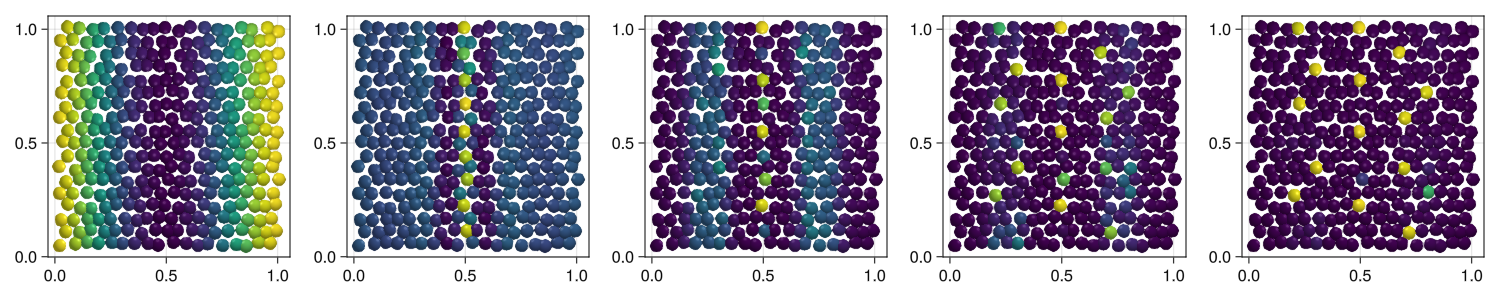

In [16]:
comOut = getParameter(com,[:u])

fig = Figure(resolution=(1500,300))

for (i,time) in enumerate(1:round(Int64,length(com)/4):length(com))
    ax = Axis(fig[1,i])
    meshscatter!(ax,com[:x],com[:y],markersize=3*10^-2,color=comOut[:u][time])
end

display(fig)
save("C:/Users/s361359/CellBasedModelsF1/results/patterning_example.png", fig)

#### Animating the results

In [17]:
using GLMakie

comOut = getParameter(com, [:u])

# Create the figure with squared dimensions
fig = Figure(resolution=(600, 600))

# Define the output file path for the GIF
output_path = "C:/Users/s361359/CellBasedModelsF1/results/patterning_example.gif"

# Create an axis in the figure for plotting
ax = Axis(fig[1, 1])

# Define observables for the scatter plot's data
x_obs = Observable(com[:x])
y_obs = Observable(com[:y])
color_obs = Observable(comOut[:u][1])

# Create the initial scatter plot
meshscatter!(ax, x_obs, y_obs, markersize=3 * 10^-2, color=color_obs)

# Function to update the data in the observables for each frame
function update_frame!(time)
    color_obs[] = comOut[:u][time]  # Update the color data
end

# Adjust the number of frames by decreasing the step size in the loop
n_frames = 20  # Increase the number of frames (e.g., 20 for smoother animation)
time_steps = 1:round(Int64, length(com) / n_frames):length(com)

# Generate the animation by updating each frame and saving it as a GIF
record(fig, output_path, time_steps; framerate = 5) do i
    time = i
    update_frame!(time)
end


"C:/Users/s361359/CellBasedModelsF1/results/patterning_example.gif"